In [106]:
!pip install numpy pandas
!pip install matplotlib seaborn plotly
!pip install scikit-learn
!pip install xgboost lightgbm
!pip install ipywidgets
!pip install transformers
!pip install torch
!pip install openai
!pip install streamlit
!pip install google-generativeai

In [86]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import plotly.express as px
import pprint
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display
try:
    from transformers import pipeline
    import openai
except ImportError:
    print("transformers or openai not installed. Skipping LLM imports.")
try:
    import streamlit as st
except ImportError:
    print("Streamlit not found — you’re probably not dashboard-pilled yet.")
import google.generativeai as genai

In [12]:
# Create fake users
users = [f"user_{i}" for i in range(10)]

In [14]:
# Assign random token balances to each user
balances = {user: random.randint(50, 150) for user in users}

In [16]:
# Convert to DataFrame for easier viewing
balance_df = pd.DataFrame(list(balances.items()), columns=['User', 'Balance'])

In [18]:
# Display the table
display(balance_df)

,User,Balance
0,user_0,74
1,user_1,73
2,user_2,64
3,user_3,140
4,user_4,136
5,user_5,89
6,user_6,86
7,user_7,114
8,user_8,82
9,user_9,95


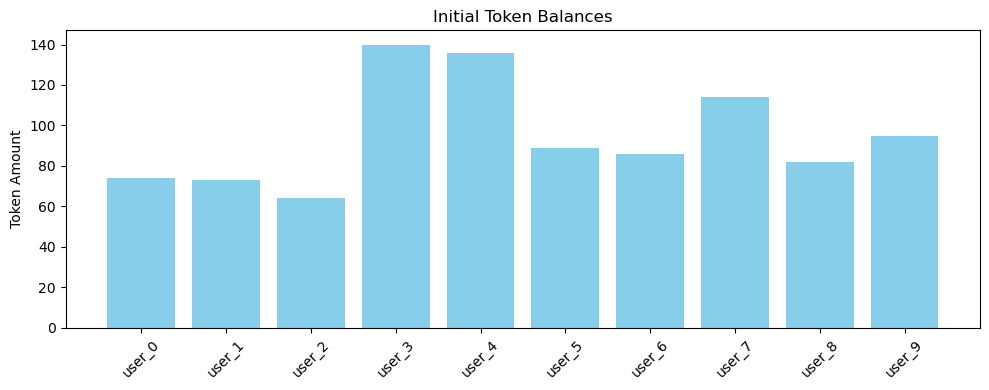

In [20]:
# Plot the initial balances
def plot_balances():
    plt.figure(figsize=(10, 4))
    plt.bar(balances.keys(), balances.values(), color='skyblue')
    plt.title("Initial Token Balances")
    plt.xticks(rotation=45)
    plt.ylabel("Token Amount")
    plt.tight_layout()
    plt.show()
plot_balances()

In [22]:
# Initialize the blockchain — a list of all confirmed transactions
blockchain = []

In [24]:
# Function to create a transaction
def create_transaction(sender, receiver, amount):
    return {
        'timestamp': time.time(),
        'sender': sender,
        'receiver': receiver,
        'amount': amount,
    }

In [26]:
# Function to simulate block hashing (for fun and illusion of legitimacy)
def hash_block(block):
    block_string = str(block).encode()
    return hashlib.sha256(block_string).hexdigest()

In [28]:
# Function to process a transaction (and add to blockchain)
def process_transaction(tx):
    sender = tx['sender']
    receiver = tx['receiver']
    amount = tx['amount']
    # Check if sender has enough tokens
    if balances.get(sender, 0) >= amount:
        balances[sender] -= amount
        balances[receiver] += amount
        block = {
            'transaction': tx,
            'hash': hash_block(tx)
        }
        blockchain.append(block)
    else:
        print(f"🚫 Transaction failed: {sender} tried to send {amount} with only {balances[sender]} tokens.")

In [30]:
# Generate a few random transactions to test the system
for _ in range(15):
    sender = random.choice(users)
    receiver = random.choice([u for u in users if u != sender])
    amount = random.randint(1, 50)
    tx = create_transaction(sender, receiver, amount)
    process_transaction(tx)

In [32]:
# Show updated balances
updated_balance_df = pd.DataFrame(list(balances.items()), columns=['User', 'Balance'])
display(updated_balance_df)

,User,Balance
0,user_0,41
1,user_1,98
2,user_2,64
3,user_3,127
4,user_4,119
5,user_5,111
6,user_6,79
7,user_7,210
8,user_8,42
9,user_9,62


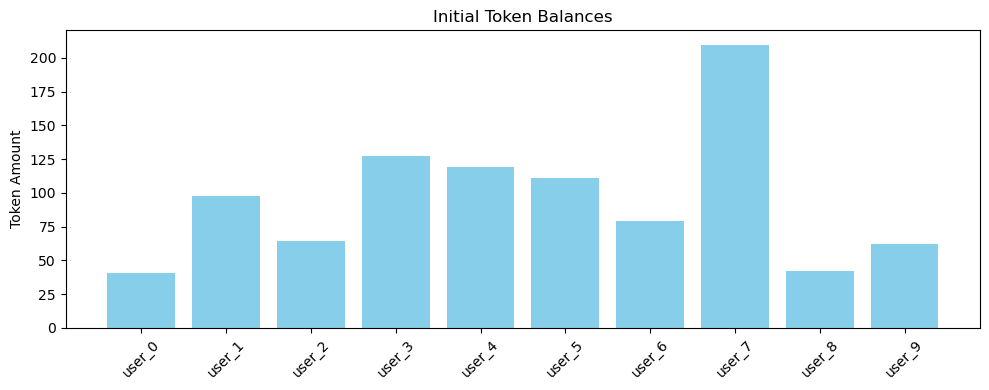

In [34]:
# Plot updated balances
plot_balances()

In [38]:
# View some recent "blocks"
print("\n Sample blockchain blocks:")
pprint.pprint(blockchain[-3:])  # Show last 3 blocks


 Sample blockchain blocks:
[{'hash': '682946d8764138c86f56afcec7c41950314921185c2f753383c4df291ce4be64',
  'transaction': {'amount': 44,
                  'receiver': 'user_1',
                  'sender': 'user_9',
                  'timestamp': 1745600628.134585}},
 {'hash': 'af81da3a9215190a982cd26495df575faf8cc7a94d38add990089299b7dcdac2',
  'transaction': {'amount': 16,
                  'receiver': 'user_7',
                  'sender': 'user_1',
                  'timestamp': 1745600628.134585}},
 {'hash': 'c038e84abe212df2fd7360607a8e7973487471464e48e201f5108ccd2374e923',
  'transaction': {'amount': 29,
                  'receiver': 'user_4',
                  'sender': 'user_1',
                  'timestamp': 1745600628.134585}}]


In [40]:
# Create a transaction log DataFrame from the blockchain
tx_data = []
for block in blockchain:
    tx = block['transaction']
    tx_data.append({
        'timestamp': tx['timestamp'],
        'sender': tx['sender'],
        'receiver': tx['receiver'],
        'amount': tx['amount']
    })
df_tx = pd.DataFrame(tx_data)

In [42]:
# Apply AI: Isolation Forest to detect anomalous amounts
model = IsolationForest(contamination=0.1, random_state=42)
df_tx['amount_scaled'] = (df_tx['amount'] - df_tx['amount'].mean()) / df_tx['amount'].std()

In [44]:
# Train model on the scaled amount (because raw numbers are rude)
model.fit(df_tx[['amount_scaled']])
df_tx['anomaly'] = model.predict(df_tx[['amount_scaled']])

In [46]:
# -1 means anomaly, 1 means normal
df_tx['is_suspicious'] = df_tx['anomaly'] == -1

In [48]:
# View flagged transactions
print("⚠️ Suspicious Transactions Detected:")
display(df_tx[df_tx['is_suspicious']])

⚠️ Suspicious Transactions Detected:


,timestamp,sender,receiver,amount,amount_scaled,anomaly,is_suspicious
5,1.745601e+09,user_4,user_7,47,1.790757,-1,True
12,1.745601e+09,user_9,user_1,44,1.594689,-1,True


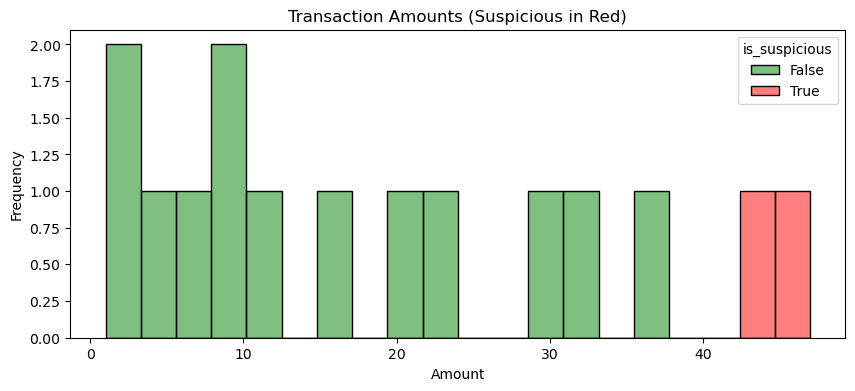

In [50]:
# Plotting Suspicious vs Normal Transactions
plt.figure(figsize=(10, 4))
sns.histplot(data=df_tx, x='amount', hue='is_suspicious', bins=20, palette={True: 'red', False: 'green'})
plt.title("Transaction Amounts (Suspicious in Red)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

In [52]:
# Step 1: Calculate user transaction counts and total sent amounts
activity_data = {user: {'sent_count': 0, 'total_sent': 0} for user in users}
for block in blockchain:
    tx = block['transaction']
    sender = tx['sender']
    amount = tx['amount']
    activity_data[sender]['sent_count'] += 1
    activity_data[sender]['total_sent'] += amount

In [54]:
# Convert to DataFrame
activity_df = pd.DataFrame([
    {'user': user, 'sent_count': vals['sent_count'], 'total_sent': vals['total_sent']}
    for user, vals in activity_data.items()
])

In [56]:
# Fill missing users (with 0 activity)
for user in users:
    if user not in activity_df['user'].values:
        activity_df = activity_df.append({'user': user, 'sent_count': 0, 'total_sent': 0}, ignore_index=True)

In [58]:
# Step 2: Cluster users into 3 groups (low, medium, high activity)
X = activity_df[['sent_count', 'total_sent']]
kmeans = KMeans(n_clusters=3, random_state=42)
activity_df['cluster'] = kmeans.fit_predict(X)

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [60]:
# Step 3: Define cluster rewards
cluster_rewards = {
    0: 5,   # Example: low activity
    1: 10,  # medium
    2: 20   # high activity
}

✅ Token rewards distributed based on activity clusters.


,user,sent_count,total_sent,cluster
0,user_0,1,33,1
1,user_1,4,56,2
2,user_2,0,0,0
3,user_3,1,20,0
4,user_4,1,47,1
5,user_5,2,11,0
6,user_6,1,23,0
7,user_7,0,0,0
8,user_8,4,60,2
9,user_9,1,44,1


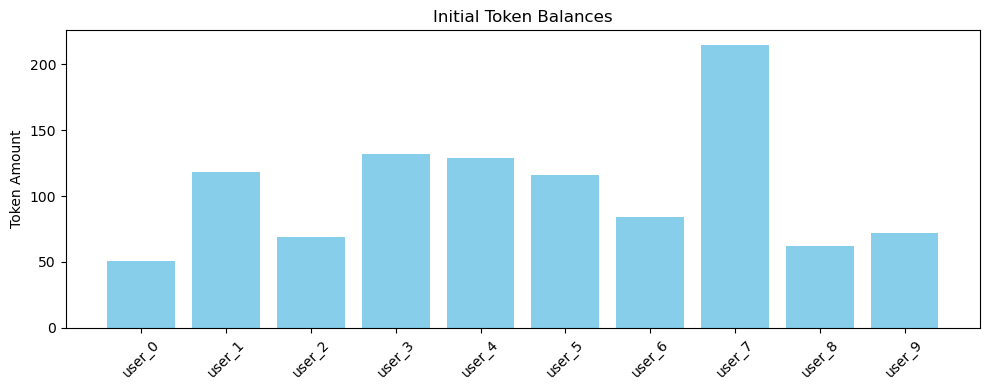

In [62]:
# 🧾 Step 4: Distribute rewards based on cluster
for _, row in activity_df.iterrows():
    user = row['user']
    cluster = row['cluster']
    reward = cluster_rewards.get(cluster, 0)
    balances[user] += reward
print("✅ Token rewards distributed based on activity clusters.")
display(activity_df)
plot_balances()

In [110]:
# Load using PyTorch only
local_ai = pipeline("text-generation", model="gpt2", framework="pt")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [116]:
def query_local_ai(prompt):
    structured_prompt = (
        f"Policy Proposal: {prompt}\n"
        f"Assessment:\n"
        f"- Pros:\n"
        f"- Cons:\n"
        f"- Recommendation:\n"
    )
    result = local_ai(structured_prompt, max_length=150, do_sample=True, temperature=0.7)
    return result[0]['generated_text']

In [118]:
# Test it
print(query_local_ai("Reward users who hold tokens longer than 6 months."))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Policy Proposal: Reward users who hold tokens longer than 6 months.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Technical:
- Cons:
- Technical:
- Cons:
- Technical:
- Cons:
- Technical:
- Cons:
- Technical:
- Technical:
- Technical:
- Technical:
- Technical:
- Technical:
/u/JHW-Frosty_Trey
/u/jhw-frosty_trey
/u/JHW-Frosty_Trey
/u/jhw-frosty_trey
/u/JHW


In [122]:
def apply_policy_effect(proposal_text):
    proposal_text = proposal_text.lower()
    if "increase rewards for new users" in proposal_text:
        # Give all users with low balances a reward
        for user, balance in balances.items():
            if balance < 100:
                balances[user] += 20
        print("🪙 Policy Applied: Boosted new/low-balance user rewards.")
    elif "penalize users who hoard" in proposal_text:
        # Reduce balance for users with high amounts
        for user, balance in balances.items():
            if balance > 140:
                balances[user] -= 15
        print("📉 Policy Applied: Hoarder penalty deducted.")
    elif "inflation" in proposal_text:
        # Global inflation - reduce everyone's purchasing power
        for user in balances:
            balances[user] = round(balances[user] * 0.9, 2)
        print("🔥 Policy Applied: Simulated inflation.")
    elif "lottery" in proposal_text:
        # Redistribute tokens from rich to poor
        rich = [u for u, b in balances.items() if b > 130]
        poor = [u for u, b in balances.items() if b < 100]
        if rich and poor:
            for r in rich:
                balances[r] -= 5
            for p in poor:
                balances[p] += 5
        print("🎰 Policy Applied: Token redistribution lottery.")
    else:
        print("🤷 No economic action taken (AI unclear or boring policy).")

In [124]:
for proposal in proposals:
    print(f"📜 Proposal: {proposal}")
    ai_response = query_local_ai(f"Evaluate this crypto policy: {proposal}")
    print("🤖 AI Ruling:\n", ai_response) 
    # Crude logic: if AI says it's a good idea, apply it
    if "pros" in ai_response.lower() or "recommendation" in ai_response.lower():
        apply_policy_effect(proposal)
    else:
        print("🚫 Policy Rejected: AI did not endorse the idea.")
    print("-" * 80)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


📜 Proposal: We should increase rewards for new users to encourage adoption.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Ruling:
 Policy Proposal: Evaluate this crypto policy: We should increase rewards for new users to encourage adoption.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Cons:
- Cons:
- Cons:
- Cons:


There is absolutely no evidence that the crypto policy is "correct" in any way. In fact, there are many examples of the policy being wrong - including a recent paper from the International Monetary Fund, which says that the crypto policy is not "corrected" in any way. I am not saying that the crypto policy is wrong, just that it is wrong.


The purpose of the discussion here is to help clarify what we are talking about. The goal is
🪙 Policy Applied: Boosted new/low-balance user rewards.
--------------------------------------------------------------------------------
📜 Proposal: Penalize users who hoard tokens and don’t transact.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Ruling:
 Policy Proposal: Evaluate this crypto policy: Penalize users who hoard tokens and don’t transact.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Adopts:
- Cons:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adopts:
- Adop
📉 Policy Applied: Hoarder penalty deducted.
--------------------------------------------------------------------------------
📜 Proposal: Introduce random inflation spikes to test system resilience.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Ruling:
 Policy Proposal: Evaluate this crypto policy: Introduce random inflation spikes to test system resilience.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Proposal: Implement a new crypto policy: Introduce random inflation spikes to test system resilience.
Assessment:- Pros:- Cons:- Recommendation:
- Proposal: Implement a new crypto policy: Introduce random inflation spikes to test system resilience.
- Cons:- Cons:- Cons:-
- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:- Cons:
- Cons:- Cons
🔥 Policy Applied: Simulated inflation.
--------------------------------------------------------------------------------
📜 Proposal: Create a weekly lottery to redistribute tokens from the top 10% to low-balance users.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Ruling:
 Policy Proposal: Evaluate this crypto policy: Create a weekly lottery to redistribute tokens from the top 10% to low-balance users.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Recommendation:
- Cons:
- Recommendation:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
-
🎰 Policy Applied: Token redistribution lottery.
--------------------------------------------------------------------------------
📜 Proposal: Reduce rewards for users who have been flagged as suspicious by the AI.
🤖 AI Ruling:
 Policy Proposal: Evaluate this crypto policy: Reduce rewards for users who have been flagged as suspicious by the AI.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Cons:
- Recommendation:
- Cons:
- Evaluate the proposal to evaluate the AI's actions.
- Cons:
- Validate the AI's work on a higher level.
- Validate the AI's work on a higher level.
- Validate 

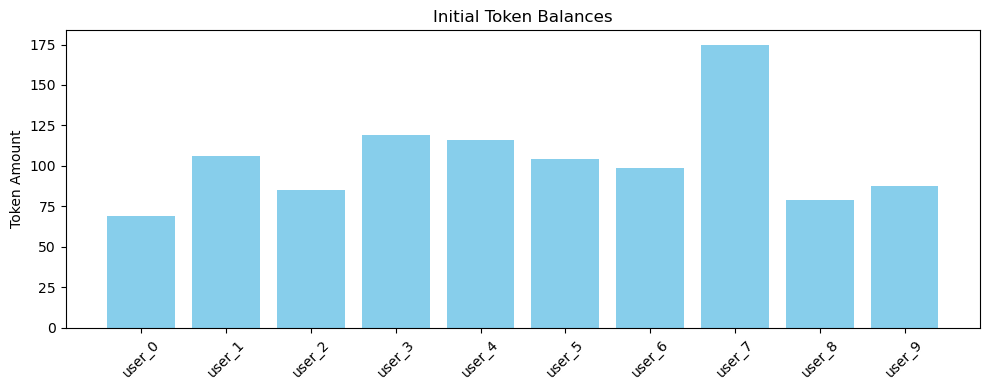

In [126]:
plot_balances()

In [128]:
#Dynamic Tax System

In [130]:
# Initialize the treasury (government bank account)
treasury = 0

In [132]:
# Modified process_transaction with tax
def process_transaction_with_tax(tx, tax_rate=0.05):  # 5% tax
    global treasury  # Important: otherwise Python cries
    sender = tx['sender']
    receiver = tx['receiver']
    amount = tx['amount']
    tax = round(amount * tax_rate, 2)
    amount_after_tax = amount - tax
    # Check if sender has enough tokens
    if balances.get(sender, 0) >= amount:
        balances[sender] -= amount
        balances[receiver] += amount_after_tax
        treasury += tax  # Tax goes into the treasury
        block = {
            'transaction': tx,
            'tax': tax,
            'treasury_balance_after': treasury,
            'hash': hash_block(tx)
        }
        blockchain.append(block)
    else:
        print(f"🚫 Transaction failed: {sender} tried to send {amount} with only {balances[sender]} tokens.")

In [134]:
print(f"🏛️ Treasury Balance: {treasury} tokens")

🏛️ Treasury Balance: 0 tokens


In [136]:
#Quick Sanity Test

In [138]:
for _ in range(15):
    sender = random.choice(users)
    receiver = random.choice([u for u in users if u != sender])
    amount = random.randint(1, 50)
    tx = create_transaction(sender, receiver, amount)
    process_transaction_with_tax(tx)  # <<< Use the taxed version!

🚫 Transaction failed: user_6 tried to send 49 with only 17.599999999999994 tokens.
🚫 Transaction failed: user_6 tried to send 46 with only 17.599999999999994 tokens.
🚫 Transaction failed: user_6 tried to send 47 with only 17.599999999999994 tokens.


In [140]:
display(pd.DataFrame(list(balances.items()), columns=["User", "Balance"]))
print(f"🏛️ Treasury Balance: {treasury} tokens")

,User,Balance
0,user_0,17.60
1,user_1,102.80
2,user_2,126.55
3,user_3,146.35
4,user_4,116.10
5,user_5,109.80
6,user_6,17.60
7,user_7,212.75
8,user_8,92.60
9,user_9,83.85


🏛️ Treasury Balance: 13.7 tokens


In [142]:
# Initialize history tracking
economy_history = {
    'block_height': [],
    'treasury_balance': [],
    'total_user_tokens': [],
    'active_users': [],
    'gini_coefficient': []
}

In [144]:
def record_economy_state():
    total_tokens = sum(balances.values())
    active = sum(1 for b in balances.values() if b > 0)
    # Calculate Gini Coefficient (wealth inequality)
    sorted_balances = np.sort(list(balances.values()))
    n = len(sorted_balances)
    cumulative = np.cumsum(sorted_balances)
    gini = (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n if cumulative[-1] > 0 else 0
    # Record the state
    economy_history['block_height'].append(len(blockchain))
    economy_history['treasury_balance'].append(treasury)
    economy_history['total_user_tokens'].append(total_tokens)
    economy_history['active_users'].append(active)
    economy_history['gini_coefficient'].append(gini)

In [146]:
# Example: Record economy state every 10 transactions
for _ in range(30):
    sender = random.choice(users)
    receiver = random.choice([u for u in users if u != sender])
    amount = random.randint(1, 50)
    tx = create_transaction(sender, receiver, amount)
    process_transaction_with_tax(tx)
    if _ % 10 == 0:
        record_economy_state()

🚫 Transaction failed: user_6 tried to send 48 with only 10.199999999999996 tokens.
🚫 Transaction failed: user_6 tried to send 20 with only 10.199999999999996 tokens.
🚫 Transaction failed: user_6 tried to send 32 with only 10.199999999999996 tokens.


In [148]:
def plot_economy_dashboard():
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    history_df = pd.DataFrame(economy_history)
    axs[0, 0].plot(history_df['block_height'], history_df['treasury_balance'], label='Treasury Balance', color='gold')
    axs[0, 0].set_title('🏛️ Treasury Over Time')
    axs[0, 0].set_xlabel('Block Height')
    axs[0, 0].set_ylabel('Tokens')
    axs[0, 1].plot(history_df['block_height'], history_df['total_user_tokens'], label='Total User Tokens', color='green')
    axs[0, 1].set_title('💰 Total Wealth in Circulation')
    axs[0, 1].set_xlabel('Block Height')
    axs[0, 1].set_ylabel('Tokens')
    axs[1, 0].plot(history_df['block_height'], history_df['active_users'], label='Active Users', color='blue')
    axs[1, 0].set_title('👥 Active Users Over Time')
    axs[1, 0].set_xlabel('Block Height')
    axs[1, 0].set_ylabel('Users')
    axs[1, 1].plot(history_df['block_height'], history_df['gini_coefficient'], label='Gini Coefficient', color='red')
    axs[1, 1].set_title('⚖️ Wealth Inequality (Gini)')
    axs[1, 1].set_xlabel('Block Height')
    axs[1, 1].set_ylabel('Gini (0=Equal, 1=Extreme Inequality)')
    for ax in axs.flat:
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) mis

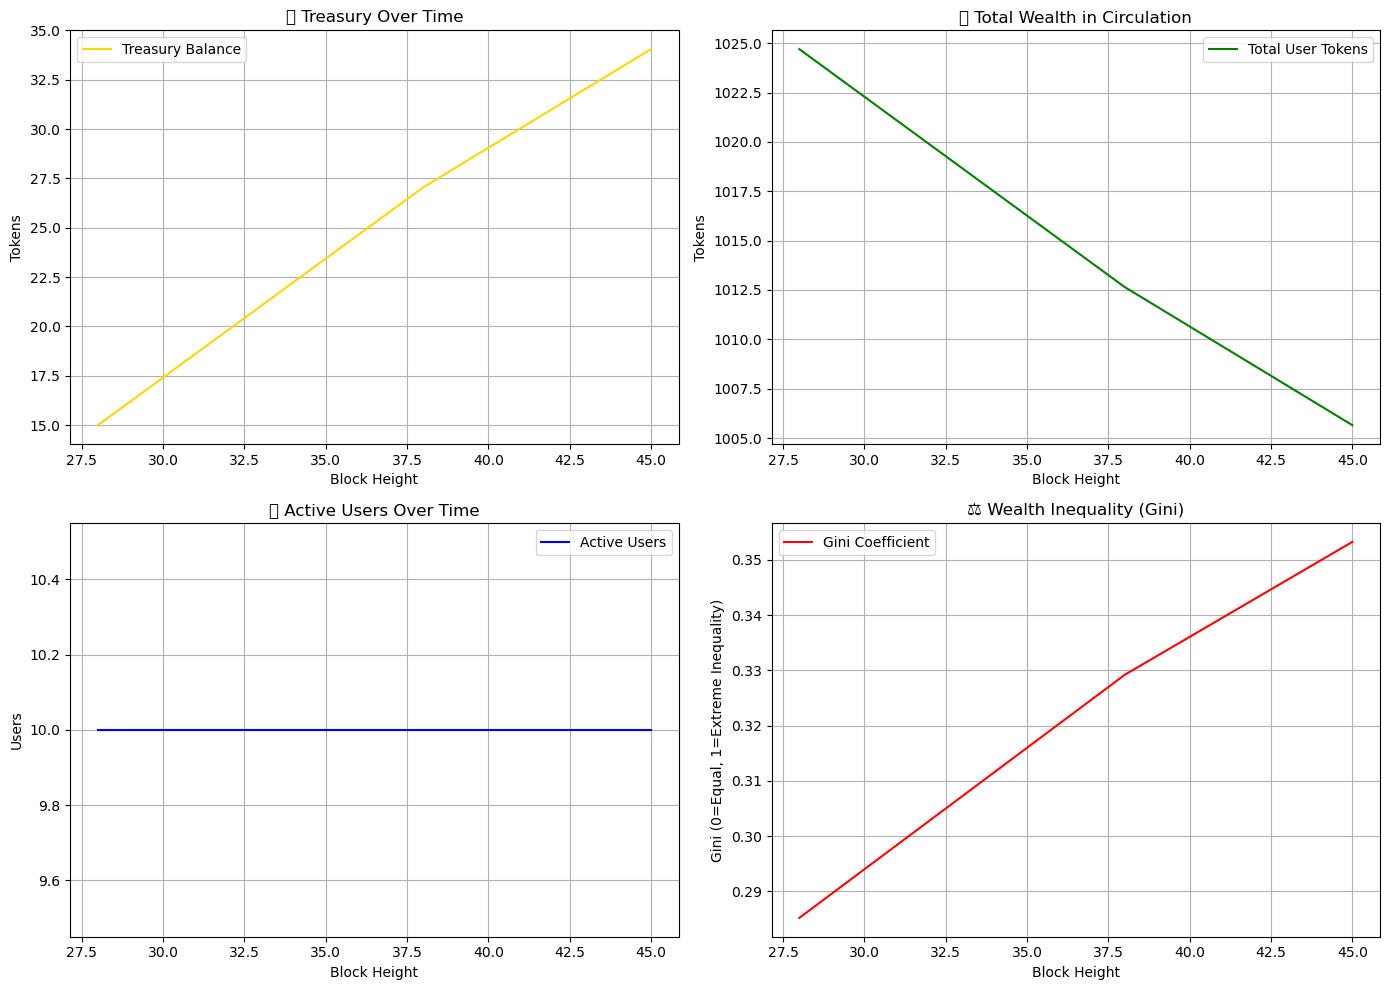

In [150]:
plot_economy_dashboard()

In [152]:
# Track behavior stats
user_stats = {
    user: {'sent': 0, 'received': 0, 'lottery_wins': 0}
    for user in users
}

In [154]:
def process_transaction_with_tax(tx, tax_rate=0.05):
    global treasury
    sender = tx['sender']
    receiver = tx['receiver']
    amount = tx['amount']
    tax = round(amount * tax_rate, 2)
    amount_after_tax = amount - tax
    if balances.get(sender, 0) >= amount:
        balances[sender] -= amount
        balances[receiver] += amount_after_tax
        treasury += tax
        user_stats[sender]['sent'] += 1
        user_stats[receiver]['received'] += 1
        block = {
            'transaction': tx,
            'tax': tax,
            'treasury_balance_after': treasury,
            'hash': hash_block(tx)
        }
        blockchain.append(block)
    else:
        print(f"🚫 Transaction failed: {sender} tried to send {amount}, has {balances[sender]}")

In [156]:
def classify_users():
    user_classes = {}
    for user in users:
        balance = balances[user]
        sent = user_stats[user]['sent']
        received = user_stats[user]['received']
        wins = user_stats[user]['lottery_wins']
        if balance == 0:
            user_classes[user] = "Zombie 🧟"
        elif sent + received > 10:
            user_classes[user] = "Trader 🔁"
        elif balance > 150 and sent < 3:
            user_classes[user] = "Hoarder 🪙"
        elif wins > 0:
            user_classes[user] = "Gambler 🎲"
        else:
            user_classes[user] = "Citizen 👤"
    return user_classes

In [158]:
def show_user_classes():
    user_classes = classify_users()
    class_df = pd.DataFrame([
        {
            'User': user,
            'Class': user_classes[user],
            'Balance': balances[user],
            'Sent TX': user_stats[user]['sent'],
            'Received TX': user_stats[user]['received'],
            'Lottery Wins': user_stats[user]['lottery_wins']
        }
        for user in users
    ])
    display(class_df.sort_values(by="Balance", ascending=False))

In [160]:
show_user_classes()

,User,Class,Balance,Sent TX,Received TX,Lottery Wins
7,user_7,Hoarder 🪙,206.50,0,0,0
2,user_2,Citizen 👤,140.20,0,0,0
6,user_6,Citizen 👤,124.20,0,0,0
4,user_4,Citizen 👤,113.00,0,0,0
3,user_3,Citizen 👤,110.85,0,0,0
5,user_5,Citizen 👤,88.50,0,0,0
8,user_8,Citizen 👤,85.60,0,0,0
1,user_1,Citizen 👤,81.10,0,0,0
9,user_9,Citizen 👤,21.20,0,0,0
0,user_0,Citizen 👤,20.95,0,0,0


In [162]:
# Random Events Engine

In [164]:
def run_random_event():
    global treasury
    event = random.choice([
        "airdrop_to_poor",
        "treasury_hack",
        "hoarder_penalty",
        "gambler_luck",
        "tax_bonus_week",
        "wealth_rebalance",
        "burn_tokens",
        "universal_income",
        "fake_nft_crash"
    ])
    print(f"🎲 RANDOM EVENT: {event.replace('_', ' ').title()}")
    if event == "airdrop_to_poor":
        for user, balance in balances.items():
            if balance < 50:
                balances[user] += 20
        print("💸 Airdrop: Poor users received +20 tokens.")
    elif event == "treasury_hack":
        stolen = round(treasury * 0.5, 2)
        treasury -= stolen
        hacker = random.choice(users)
        balances[hacker] += stolen
        print(f"💀 Treasury Hack: {hacker} stole {stolen} tokens!")
    elif event == "hoarder_penalty":
        for user, balance in balances.items():
            if balance > 150:
                penalty = 10
                balances[user] -= penalty
                treasury += penalty
        print("🪙 Hoarders lost 10 tokens each to a wealth tax.")
    elif event == "gambler_luck":
        lucky = random.choice(users)
        balances[lucky] += 50
        user_stats[lucky]['lottery_wins'] += 1
        print(f"🎰 Gambler Luck: {lucky} won 50 tokens out of nowhere.")
    elif event == "tax_bonus_week":
        treasury += 100
        print("🏛️ Stimulus: Treasury magically grew by 100 tokens.")
    elif event == "wealth_rebalance":
        # Flatten the curve: take from rich, give to poor
        rich = [u for u, b in balances.items() if b > 140]
        poor = [u for u, b in balances.items() if b < 60]
        for r in rich:
            balances[r] -= 15
        for p in poor:
            balances[p] += 15
        print("⚖️ Wealth Rebalance: 15 tokens moved from rich to poor.")
    elif event == "burn_tokens":
        # Burn 5% of all user balances
        for u in balances:
            balances[u] = round(balances[u] * 0.95, 2)
        print("🔥 Token Burn: 5% of all tokens gone.")
    elif event == "universal_income":
        for u in balances:
            balances[u] += 10
        print("💰 UBI: All users gained +10 tokens.")
    elif event == "fake_nft_crash":
        victim = random.choice(users)
        loss = min(30, balances[victim])
        balances[victim] -= loss
        print(f"🖼️ NFT Market Crash: {victim} lost {loss} tokens in a JPEG-based financial crisis.")
    record_economy_state()

In [166]:
run_random_event()

🎲 RANDOM EVENT: Tax Bonus Week
🏛️ Stimulus: Treasury magically grew by 100 tokens.


In [168]:
for i in range(30):
    sender = random.choice(users)
    receiver = random.choice([u for u in users if u != sender])
    amount = random.randint(1, 50)
    tx = create_transaction(sender, receiver, amount)
    process_transaction_with_tax(tx)
    if i % 10 == 0:
        run_random_event()

🎲 RANDOM EVENT: Tax Bonus Week
🏛️ Stimulus: Treasury magically grew by 100 tokens.
🚫 Transaction failed: user_0 tried to send 36, has 20.950000000000003
🎲 RANDOM EVENT: Treasury Hack
💀 Treasury Hack: user_3 stole 131.28 tokens!
🎲 RANDOM EVENT: Fake Nft Crash
🖼️ NFT Market Crash: user_8 lost 30 tokens in a JPEG-based financial crisis.


C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) mis

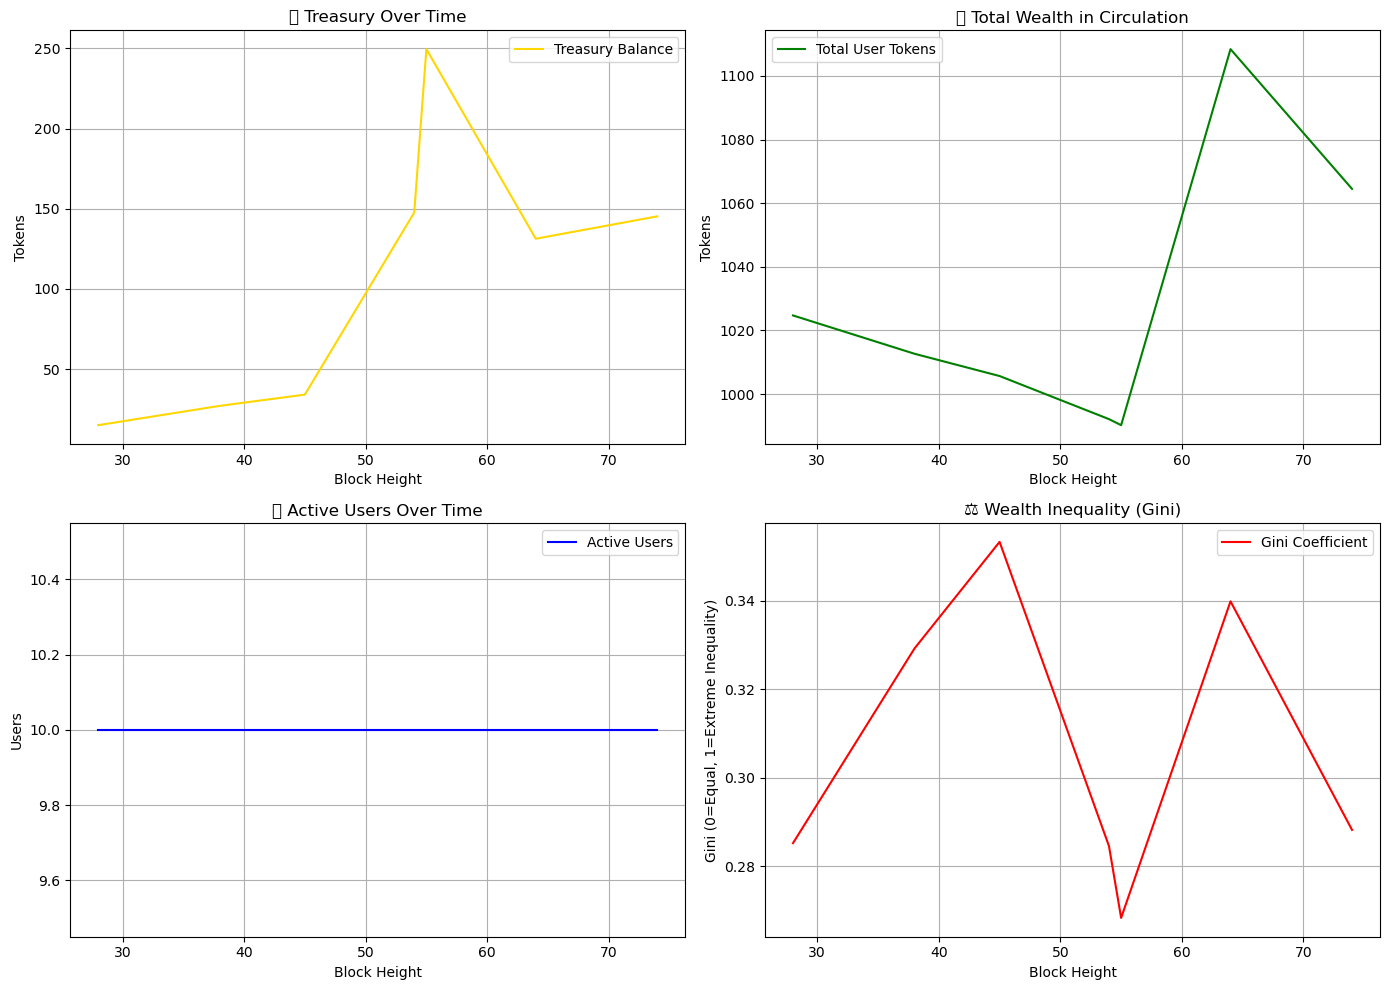

,User,Class,Balance,Sent TX,Received TX,Lottery Wins
4,user_4,Hoarder 🪙,231.05,1,4,0
7,user_7,Trader 🔁,177.30,6,6,0
8,user_8,Citizen 👤,136.80,3,5,0
0,user_0,Citizen 👤,118.80,0,4,0
3,user_3,Citizen 👤,107.13,3,0,0
1,user_1,Citizen 👤,99.45,4,4,0
5,user_5,Citizen 👤,80.90,3,2,0
9,user_9,Citizen 👤,55.75,1,3,0
2,user_2,Citizen 👤,36.65,4,1,0
6,user_6,Citizen 👤,10.20,4,0,0


In [170]:
plot_economy_dashboard()
show_user_classes()

In [172]:
# SMART USER AGENTS

In [174]:
def user_behavior(user):
    balance = balances[user]
    sent = user_stats[user]['sent']
    received = user_stats[user]['received']
    wins = user_stats[user]['lottery_wins']
    # Behaviors based on balance and stats
    if balance == 0:
        return "beg"  # Zombie behavior
    elif balance < 50:
        return random.choice(["beg", "gamble", "small_trade"])
    elif balance > 150 and sent < 3:
        return random.choice(["hoard", "minimal_trade"])
    elif sent + received > 10:
        return random.choice(["trade", "big_trade"])
    elif wins > 0:
        return random.choice(["gamble", "high_risk_trade"])
    else:
        return random.choice(["trade", "hold", "gamble"])

In [178]:
def act_on_behavior(user):
    global treasury 
    action = user_behavior(user)   
    if action == "beg":
        treasury_donation = 5
        if treasury >= treasury_donation:
            balances[user] += treasury_donation
            treasury -= treasury_donation
            print(f"🧟 {user} begged and got {treasury_donation} tokens from treasury.")
    elif action == "gamble":
        if balances[user] >= 5:
            gamble_result = random.choice([-5, 10, 20])
            balances[user] += gamble_result
            user_stats[user]['lottery_wins'] += 1 if gamble_result > 0 else 0
            print(f"🎲 {user} gambled and {'won' if gamble_result > 0 else 'lost'} {abs(gamble_result)} tokens.")
    elif action == "small_trade":
        receiver = random.choice([u for u in users if u != user])
        amount = random.randint(1, 10)
        tx = create_transaction(user, receiver, amount)
        process_transaction_with_tax(tx)
    elif action == "big_trade":
        receiver = random.choice([u for u in users if u != user])
        amount = random.randint(20, 50)
        tx = create_transaction(user, receiver, amount)
        process_transaction_with_tax(tx)
    elif action == "hoard":
        print(f"🪙 {user} is hoarding. No movement this round.")
    elif action == "minimal_trade":
        if random.random() < 0.2:  # 20% chance they send a tiny transaction
            receiver = random.choice([u for u in users if u != user])
            amount = 1
            tx = create_transaction(user, receiver, amount)
            process_transaction_with_tax(tx)
    elif action == "high_risk_trade":
        receiver = random.choice([u for u in users if u != user])
        amount = random.randint(30, 70)
        tx = create_transaction(user, receiver, amount)
        process_transaction_with_tax(tx)
    elif action == "trade":
        receiver = random.choice([u for u in users if u != user])
        amount = random.randint(5, 25)
        tx = create_transaction(user, receiver, amount)
        process_transaction_with_tax(tx)
    elif action == "hold":
        print(f"🤷 {user} is just holding their coins this round.")

In [180]:
def run_smart_economy_round():
    print("=== SMART ECONOMY ROUND START ===")
    for user in users:
        act_on_behavior(user)
    record_economy_state()
    print("=== ROUND END ===")

In [182]:
for _ in range(3):
    run_smart_economy_round()
    run_random_event()

=== SMART ECONOMY ROUND START ===
🎲 user_0 gambled and won 10 tokens.
🤷 user_1 is just holding their coins this round.
🧟 user_2 begged and got 5 tokens from treasury.
🪙 user_4 is hoarding. No movement this round.
🎲 user_5 gambled and won 20 tokens.
🧟 user_6 begged and got 5 tokens from treasury.
🤷 user_8 is just holding their coins this round.
🤷 user_9 is just holding their coins this round.
=== ROUND END ===
🎲 RANDOM EVENT: Hoarder Penalty
🪙 Hoarders lost 10 tokens each to a wealth tax.
=== SMART ECONOMY ROUND START ===
🤷 user_1 is just holding their coins this round.
🎲 user_2 gambled and won 20 tokens.
🎲 user_3 gambled and lost 5 tokens.
🎲 user_8 gambled and lost 5 tokens.
🎲 user_9 gambled and won 20 tokens.
=== ROUND END ===
🎲 RANDOM EVENT: Universal Income
💰 UBI: All users gained +10 tokens.
=== SMART ECONOMY ROUND START ===
🎲 user_0 gambled and won 20 tokens.
🎲 user_1 gambled and won 20 tokens.
🎲 user_2 gambled and lost 5 tokens.
🎲 user_3 gambled and won 20 tokens.
🪙 user_4 is hoa

C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aniru\AppData\Local\Temp\ipykernel_9224\3096609475.py:23: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) mis

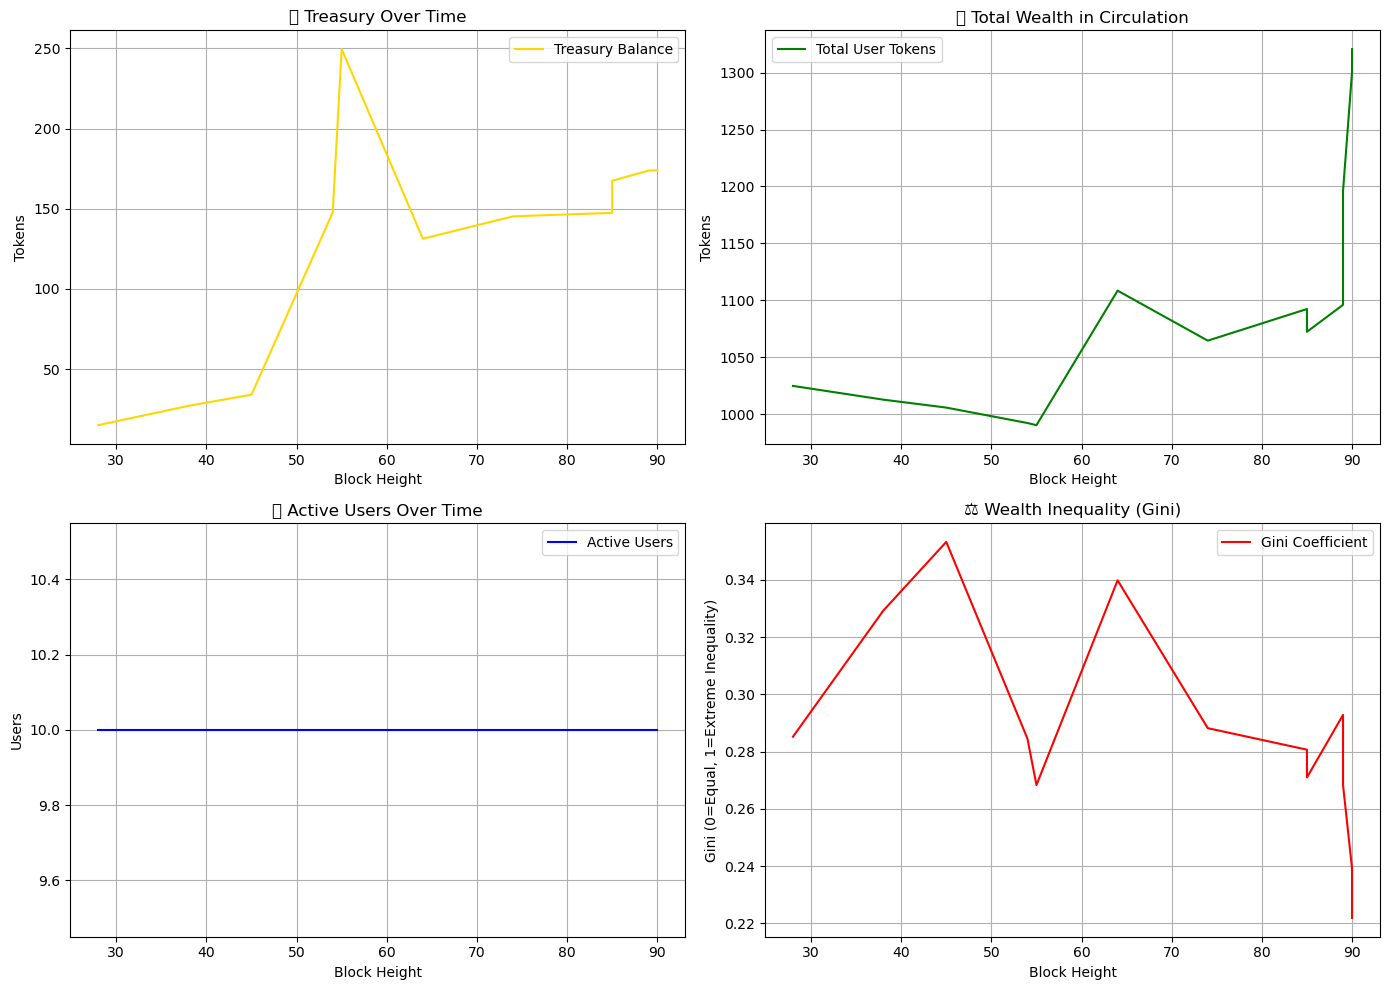

,User,Class,Balance,Sent TX,Received TX,Lottery Wins
4,user_4,Hoarder 🪙,231.05,1,4,0
3,user_3,Gambler 🎲,183.93,4,2,1
8,user_8,Citizen 👤,173.15,3,6,0
0,user_0,Hoarder 🪙,153.35,1,5,2
1,user_1,Gambler 🎲,135.15,4,5,1
7,user_7,Trader 🔁,116.30,9,6,0
9,user_9,Gambler 🎲,105.75,1,3,2
2,user_2,Gambler 🎲,91.35,4,2,1
5,user_5,Gambler 🎲,84.45,4,3,2
6,user_6,Gambler 🎲,46.20,5,0,1


In [184]:
plot_economy_dashboard()
show_user_classes()

In [186]:
# SMART PROPOSAL GENERATOR

In [188]:
def generate_policy_proposal():
    actions = [
        "increase rewards", "decrease rewards", "penalize", "tax", "subsidize", 
        "airdrop", "burn", "redistribute", "freeze", "lottery"
    ]
    targets = [
        "new users", "hoarders", "frequent traders", "inactive accounts", 
        "random wallets", "top 10% of rich users", "poor users", "all users"
    ]
    conditions = [
        "weekly", "monthly", "if inflation exceeds 10%", "during economic crashes", 
        "after a hack", "once per season", "after every 100 transactions"
    ]
    action = random.choice(actions)
    target = random.choice(targets)
    condition = random.choice(conditions)
    return f"{action.capitalize()} for {target} {condition}."

In [190]:
def evaluate_policy_with_ai(proposal):
    evaluation = query_local_ai(f"Evaluate this crypto policy: {proposal}")
    return evaluation

In [192]:
def propose_and_apply_policy():
    proposal = generate_policy_proposal()
    print(f"📜 New Proposed Policy: {proposal}")
    evaluation = evaluate_policy_with_ai(proposal)
    print(f"🤖 AI Evaluation:\n{evaluation}")
    if "pros" in evaluation.lower() or "recommendation" in evaluation.lower():
        apply_policy_effect(proposal)
        print("✅ Policy Applied to Economy.")
    else:
        print("🚫 Policy Rejected: AI did not endorse.")
    record_economy_state()

In [194]:
for _ in range(3):
    propose_and_apply_policy()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


📜 New Proposed Policy: Burn for new users monthly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Evaluation:
Policy Proposal: Evaluate this crypto policy: Burn for new users monthly.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Cons:
- Pros:
- Cons:
- Cons:
- Pros:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:

🤷 No economic action taken (AI unclear or boring policy).
✅ Policy Applied to Economy.
📜 New Proposed Policy: Redistribute for new users monthly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Evaluation:
Policy Proposal: Evaluate this crypto policy: Redistribute for new users monthly.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons
🤷 No economic action taken (AI unclear or boring policy).
✅ Policy Applied to Economy.
📜 New Proposed Policy: Airdrop for all users once per season.
🤖 AI Evaluation:
Policy Proposal: Evaluate this crypto policy: Airdrop for all users once per season.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Reviewer:
- Reviewer's Comment:
Adopted:
- Proposal: Evaluate this crypto policy: Airdrop for all users once per season.Cons:
🤷 No economic action taken (AI unclear or boring policy).
✅ Policy Applied to Economy.


In [196]:
# Governance Voting

In [198]:
def user_vote(user, proposal):
    user_classification = classify_users()[user]
    # Simple psychology based on class
    if "Hoarder" in user_classification:
        # Hoarders resist taxes and penalties
        if any(word in proposal.lower() for word in ["penalize", "tax", "burn"]):
            return "no"
        else:
            return "yes"
    elif "Trader" in user_classification:
        # Traders love liquidity and bonuses
        if any(word in proposal.lower() for word in ["increase rewards", "airdrop", "lottery", "subsidize"]):
            return "yes"
        else:
            return random.choice(["yes", "no"])
    elif "Gambler" in user_classification:
        # Gamblers say yes to everything chaotic
        return random.choice(["yes", "yes", "no"])
    elif "Zombie" in user_classification:
        # Zombies don't vote (they're broke and sad)
        return "abstain"
    else:
        # Citizens are split
        return random.choice(["yes", "no"])

In [200]:
def tally_votes(proposal):
    votes = {"yes": 0, "no": 0, "abstain": 0}
    for user in users:
        vote = user_vote(user, proposal)
        votes[vote] += 1
    print(f"🗳️ Voting Results: {votes}")
    return votes

In [202]:
def policy_decision_from_votes(votes):
    total_votes = votes['yes'] + votes['no']
    if total_votes == 0:
        print("⚠️ No votes cast. Policy rejected by apathy.")
        return False
    approval_rate = votes['yes'] / total_votes
    if approval_rate >= 0.5:
        print(f"✅ Policy approved with {approval_rate*100:.2f}% yes votes.")
        return True
    else:
        print(f"🚫 Policy rejected with only {approval_rate*100:.2f}% yes votes.")
        return False

In [204]:
def propose_vote_and_apply_policy():
    proposal = generate_policy_proposal()
    print(f"\n📜 New Proposed Policy: {proposal}")
    votes = tally_votes(proposal)
    approved = policy_decision_from_votes(votes)
    if approved:
        evaluation = evaluate_policy_with_ai(proposal)
        print(f"🤖 AI Evaluation:\n{evaluation}")
        if "pros" in evaluation.lower() or "recommendation" in evaluation.lower():
            apply_policy_effect(proposal)
            print("✅ Policy Applied to Economy.")
        else:
            print("🤖 AI rejected the proposal after voting. No action taken.")
    else:
        print("🚫 Policy rejected. No action.")
    record_economy_state()

In [206]:
for _ in range(3):
    propose_vote_and_apply_policy()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



📜 New Proposed Policy: Burn for poor users during economic crashes.
🗳️ Voting Results: {'yes': 5, 'no': 5, 'abstain': 0}
✅ Policy approved with 50.00% yes votes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Evaluation:
Policy Proposal: Evaluate this crypto policy: Burn for poor users during economic crashes.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Recommendation:
- Cons:
- Cons:
- Recommendation:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
- Cons:
Cons:
- Cons:
Cons:
- Cons:
Pros:
- Cons:
Cons:
- Cons:
Cons:
Pros:
Cons:
Cons:
Cons:
Cons:
Cons:
Cons: Cons:
Cons:
Cons: Cons:
Pros:
Pros:
Cons:
Cons
🤷 No economic action taken (AI unclear or boring policy).
✅ Policy Applied to Economy.

📜 New Proposed Policy: Decrease rewards for inactive accounts after a hack.
🗳️ Voting Results: {'yes': 7, 'no': 3, 'abstain': 0}
✅ Policy approved with 70.00% yes votes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 AI Evaluation:
Policy Proposal: Evaluate this crypto policy: Decrease rewards for inactive accounts after a hack.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Cons:
The crypto policy was developed in the last 5 years and it is not implemented in a mature way.
Pros:
- Cons:
- Cons:
- Cons:
Pros:
- Cons:
Pros:
- Cons:
Pros:
Pros:
Pros:
Cons:
Pros:
Cons:
Pros:
Cons:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros:
Pros
🤷 No economic action taken (AI unclear or boring policy).
✅ Policy Applied to Economy.

📜 New Proposed Policy: Airdrop for random wallets once per season.
🗳️ Voting Results: {'yes': 7, 'no': 3, 'abstain': 0}
✅ Policy approved with 70.00% yes votes.
🤖 AI Evaluation:
Policy Proposal: Evaluate this crypto policy: Airdrop for random wallets once per season.
Assessment:
- Pros:
- Cons:
- Recommendation:
- Proposal not given, no evidence to support it.
- Recommendation given to Coinhive for verification of the PoW PoW PoW PoW PoW POW PoW PoW PoW PoW PoW PoW 

In [208]:
# STREAMLIT DASHBOARD GO

In [210]:
# Dummy economy history if needed
economy_history = {
    'block_height': [],
    'treasury_balance': [],
    'total_user_tokens': [],
    'active_users': [],
    'gini_coefficient': []
}
st.set_page_config(page_title="Fake Crypto Economy", layout="wide")
st.title("🏛️ Fake Crypto Economy Simulator")
# Sidebar Controls
with st.sidebar:
    st.header("Simulation Controls")
    if st.button("📜 Propose + Vote on Policy"):
        propose_vote_and_apply_policy()
    if st.button("🎲 Trigger Random Event"):
        run_random_event()
    if st.button("🏃‍♂️ Run Smart economy Round"):
        run_smart_economy_round()
    if st.button("🧹 Reset Economy"):
        st.warning("Manual reset not implemented yet. Restart the app.")
# Display Economy Stats
st.subheader("📊 Economy Overview")
col1, col2, col3, col4 = st.columns(4)
col1.metric("Treasury Balance", f"{treasury} tokens")
col2.metric("Total User Tokens", f"{sum(balances.values())} tokens")
col3.metric("Active Users", sum(1 for b in balances.values() if b > 0))
col4.metric("Wealth Inequality (Gini)", f"{economy_history['gini_coefficient'][-1]:.2f}" if economy_history['gini_coefficient'] else "N/A")
# Plot Economy Dashboard
st.subheader("📈 Economic Trends")
history_df = pd.DataFrame(economy_history)
if not history_df.empty:
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs[0, 0].plot(history_df['block_height'], history_df['treasury_balance'], label='Treasury Balance', color='gold')
    axs[0, 0].set_title('🏛️ Treasury Over Time')
    axs[0, 1].plot(history_df['block_height'], history_df['total_user_tokens'], label='Total User Tokens', color='green')
    axs[0, 1].set_title('💰 Total User Wealth')
    axs[1, 0].plot(history_df['block_height'], history_df['active_users'], label='Active Users', color='blue')
    axs[1, 0].set_title('👥 Active Users')
    axs[1, 1].plot(history_df['block_height'], history_df['gini_coefficient'], label='Gini Coefficient', color='red')
    axs[1, 1].set_title('⚖️ Wealth Inequality')
    for ax in axs.flat:
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    st.pyplot(fig)
else:
    st.info("No economy history recorded yet. Run some simulations first!")

2025-04-25 15:22:49.662 
  command:

    streamlit run C:\Anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
